# Feature Engineering

## 1. Importación de Librerías

In [1]:
# Utilidades generales
from datetime import datetime, timedelta
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# Manejo y procesamiento de datos
import pandas as pd
from tabulate import tabulate

# Calendario de mercados
import pandas_market_calendars as mcal

In [2]:
#IMPORTACIÓN DE LIBRERÍAS 

# -------------------------
# Utilidades generales
# -------------------------
from datetime import datetime, timedelta
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# Manejo y procesamiento de datos
# -------------------------
import pandas as pd
import numpy as np
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------
# Visualización
# -------------------------
import matplotlib.pyplot as plt

# -------------------------
# Calendario de mercados
# -------------------------
import pandas_market_calendars as mcal

# -------------------------
# Estadística y series temporales
# -------------------------
##from statsmodels.tsa.stattools import adfuller
##from statsmodels.graphics.tsaplots import plot_predict
##from statsmodels.tsa.statespace.sarimax import SARIMAX
##from statsmodels.tsa.arima.model import ARIMA as sm_ARIMA
##from statsmodels.tsa.seasonal import seasonal_decompose
##from pmdarima.arima import ARIMA as pm_ARIMA
##import pmdarima as pm
##from arch import arch_model

# -------------------------
# Modelado con LSTM
# -------------------------
##from keras.models import Sequential
##from keras.layers import LSTM, Dense, Dropout
##from keras.preprocessing.sequence import TimeseriesGenerator

# -------------------------
# Paralelización
# -------------------------
##from joblib import parallel_backend


## 2. Carga del dataset mnq_intraday_data

In [3]:
def cargar_df():
    #path = '0_preprocesamiento_datos/mnq_intraday_data.parquet' 
    archivo = './mnq_intraday_data.parquet'

    if os.path.exists(archivo):
        print("Archivo encontrado. Cargando dataset desde disco...")
        mnq_intraday = pd.read_parquet(archivo)
        
    return mnq_intraday

In [4]:
mnq_intraday = cargar_df()

Archivo encontrado. Cargando dataset desde disco...


In [5]:
# Asegurar que el índice esté en formato datetime (por si acaso)
mnq_intraday.index = pd.to_datetime(mnq_intraday.index)

# Crear una columna 'date' a partir del índice
mnq_intraday['date'] = mnq_intraday.index.date

## 3. Búsqueda de ALPHA FACTOR    

Un alpha factor es como una hipótesis cuantitativa: propone que una cierta transformación de los datos (por ejemplo, un RSI bajo o un volumen inusualmente alto) podría anticipar un movimiento futuro del precio.

Entonces, antes de entrenar un modelo LSTM, XGBoost o cualquier otro, el alpha factor te ayuda a descubrir cuáles features tienen “potencial predictivo”

**¿Qué hace realmente?**

- Evalúa si una variable (feature) tiene relación estadística con el retorno futuro.
- Te filtra las señales útiles del ruido.
- Acelera la selección de features sin tener que probar todo con modelos complejos primero.

Por ejemplo:

- Calculás el momentum 10 y ves que cuando es alto, el retorno a 5 minutos tiende a ser positivo → ese factor tiene alpha.
- Calculás el RSI 14 y no ves ninguna relación → ese factor no tiene alpha (en ese timeframe).

El Information Coefficient (IC) mide la correlación entre el alpha factor y el retorno futuro:

IC > 0: el factor predice correctamente la dirección del retorno.

IC ≈ 0: el factor no tiene poder predictivo.

IC < 0: el factor tiene un poder inverso (indica lo contrario al retorno real).

In [ ]:
# Añadimos el momentum para 5, 15 y 30 minutos.
mnq_intraday['momentum_5'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x) - np.log(x.shift(5)))
mnq_intraday['momentum_15'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x) - np.log(x.shift(15)))
mnq_intraday['momentum_30'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x) - np.log(x.shift(30)))

# Definimos el retorno futuro:

mnq_intraday['target_return_5'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x.shift(-5)) - np.log(x))
mnq_intraday['target_return_15'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x.shift(-15)) - np.log(x))
mnq_intraday['target_return_30'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x.shift(-30)) - np.log(x))



Mean IC (Momentum 5 min):  -0.0308
Mean IC (Momentum 15 min): -0.0593
Mean IC (Momentum 30 min): -0.1094


In [ ]:
import numpy as np
import pandas as pd

# Construcción del alpha factor: momentum x (volume / rolling mean of volume)
for N in [5, 15, 30]:
    momentum_col = f'momentum_{N}'
    vol_avg_col = f'vol_avg_{N}'
    vol_ratio_col = f'vol_ratio_{N}'
    factor_col = f'mom_vol_{N}'
    z_col = f'mom_vol_z_{N}'

    # Calcular volumen promedio intradía (rolling)
    mnq_intraday[vol_avg_col] = mnq_intraday.groupby('date')['volume'].transform(
        lambda x: x.rolling(window=N, min_periods=1).mean()
    )

    # Calcular ratio volumen
    mnq_intraday[vol_ratio_col] = mnq_intraday['volume'] / mnq_intraday[vol_avg_col]

    # Alpha factor: momentum * ratio volumen
    mnq_intraday[factor_col] = mnq_intraday[momentum_col] * mnq_intraday[vol_ratio_col]

    # Normalizar por día (z-score)
    mnq_intraday[z_col] = mnq_intraday.groupby('date')[factor_col].transform(
        lambda x: (x - x.mean()) / x.std()
    )

# Evaluación: calcular IC (correlación entre factor y retorno futuro)
ic_mv_5 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['mom_vol_z_5'].corr(x['target_return_5'])
)
ic_mv_15 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['mom_vol_z_15'].corr(x['target_return_15'])
)
ic_mv_30 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['mom_vol_z_30'].corr(x['target_return_30'])
)

# Promedio de los IC
mean_ic_mv_5 = ic_mv_5.mean()
mean_ic_mv_15 = ic_mv_15.mean()
mean_ic_mv_30 = ic_mv_30.mean()

# Mostrar resultados
print(f"Mean IC (Momentum x Volume - 5 min):  {mean_ic_mv_5:.4f}")
print(f"Mean IC (Momentum x Volume - 15 min): {mean_ic_mv_15:.4f}")
print(f"Mean IC (Momentum x Volume - 30 min): {mean_ic_mv_30:.4f}")

Mean IC (Momentum x Volume - 5 min):  -0.0305
Mean IC (Momentum x Volume - 15 min): -0.0592
Mean IC (Momentum x Volume - 30 min): -0.0981


1. Signo negativo:
    
    El hecho de que los IC sean negativos indica que el alpha factor está correlacionado inversamente con los retornos futuros. Es decir:

    - Cuando el precio sube con alto volumen, tiende a revertir en lugar de continuar.

    Esto contradice la hipótesis original que asume confirmación de dirección.

2. Magnitud creciente con la ventana:
    
    El efecto se vuelve más fuerte (más negativo) a medida que aumenta el horizonte de predicción. Esto sugiere que:
    
    - En el corto plazo (5 min) la señal es más débil (quizás ruido).
    - En horizontes mayores (15-30 min), el mercado tiende a corregir movimientos bruscos con alto volumen.


Agregar filtros de volumen extremo (e.g., percentil 80+):
Solo considerar el factor cuando el volumen es significativamente alto.

Graficar el IC por minuto intradía para ver si hay patrones según la hora.

### Invertir el factor para evaluar si mejora el IC:

mnq_intraday[factor_col] = -1 * mnq_intraday[momentum_col] * mnq_intraday[vol_ratio_col]

Esto está probando una nueva hipótesis:

“Cuando hay un gran movimiento de precio con alto volumen, la dirección tiende a revertirse.”

Esto convierte el alpha factor en un indicador de reversión en lugar de continuación.

In [14]:
import numpy as np
import pandas as pd

# Construcción del alpha factor: momentum x (volume / rolling mean of volume)
for N in [5, 15, 30]:
    momentum_col = f'momentum_{N}'
    vol_avg_col = f'vol_avg_{N}'
    vol_ratio_col = f'vol_ratio_{N}'
    factor_col = f'mom_vol_{N}'
    z_col = f'mom_vol_z_{N}'

    # Calcular volumen promedio intradía (rolling)
    mnq_intraday[vol_avg_col] = mnq_intraday.groupby('date')['volume'].transform(
        lambda x: x.rolling(window=N, min_periods=1).mean()
    )

    # Calcular ratio volumen
    mnq_intraday[vol_ratio_col] = mnq_intraday['volume'] / mnq_intraday[vol_avg_col]

    # Alpha factor: momentum * ratio volumen
    mnq_intraday[factor_col] = -1 * mnq_intraday[momentum_col] * mnq_intraday[vol_ratio_col]

    # Normalizar por día (z-score)
    mnq_intraday[z_col] = mnq_intraday.groupby('date')[factor_col].transform(
        lambda x: (x - x.mean()) / x.std()
    )

# Evaluación: calcular IC (correlación entre factor y retorno futuro)
ic_mv_5 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['mom_vol_z_5'].corr(x['target_return_5'])
)
ic_mv_15 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['mom_vol_z_15'].corr(x['target_return_15'])
)
ic_mv_30 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['mom_vol_z_30'].corr(x['target_return_30'])
)

# Promedio de los IC
mean_ic_mv_5 = ic_mv_5.mean()
mean_ic_mv_15 = ic_mv_15.mean()
mean_ic_mv_30 = ic_mv_30.mean()

# Mostrar resultados
print(f"Mean IC (Momentum x Volume - 5 min):  {mean_ic_mv_5:.4f}")
print(f"Mean IC (Momentum x Volume - 15 min): {mean_ic_mv_15:.4f}")
print(f"Mean IC (Momentum x Volume - 30 min): {mean_ic_mv_30:.4f}")

Mean IC (Momentum x Volume - 5 min):  0.0305
Mean IC (Momentum x Volume - 15 min): 0.0592
Mean IC (Momentum x Volume - 30 min): 0.0981


✅ Conclusión clara:
Tu alpha factor de la hipótesis 3 (volumen como confirmación de dirección) en realidad:

**Funciona mejor como un factor de reversión.**

Es decir, si el precio se mueve fuertemente con mucho volumen, lo más probable es que revierta.

📈 Resultados tras invertir el signo:

IC promedio positivo indica que el nuevo factor ahora predice correctamente la dirección del retorno futuro (bajo tu nueva hipótesis de reversión).

La magnitud crece con la ventana, lo que refuerza que el efecto se manifiesta con más claridad a los 30 minutos.

### Agregar filtros de volumen extremo (e.g., percentil 80+):


Solo considerar el factor cuando el volumen es significativamente alto.

## Quiero observar el comportamiento del alpha factor por minutos del día

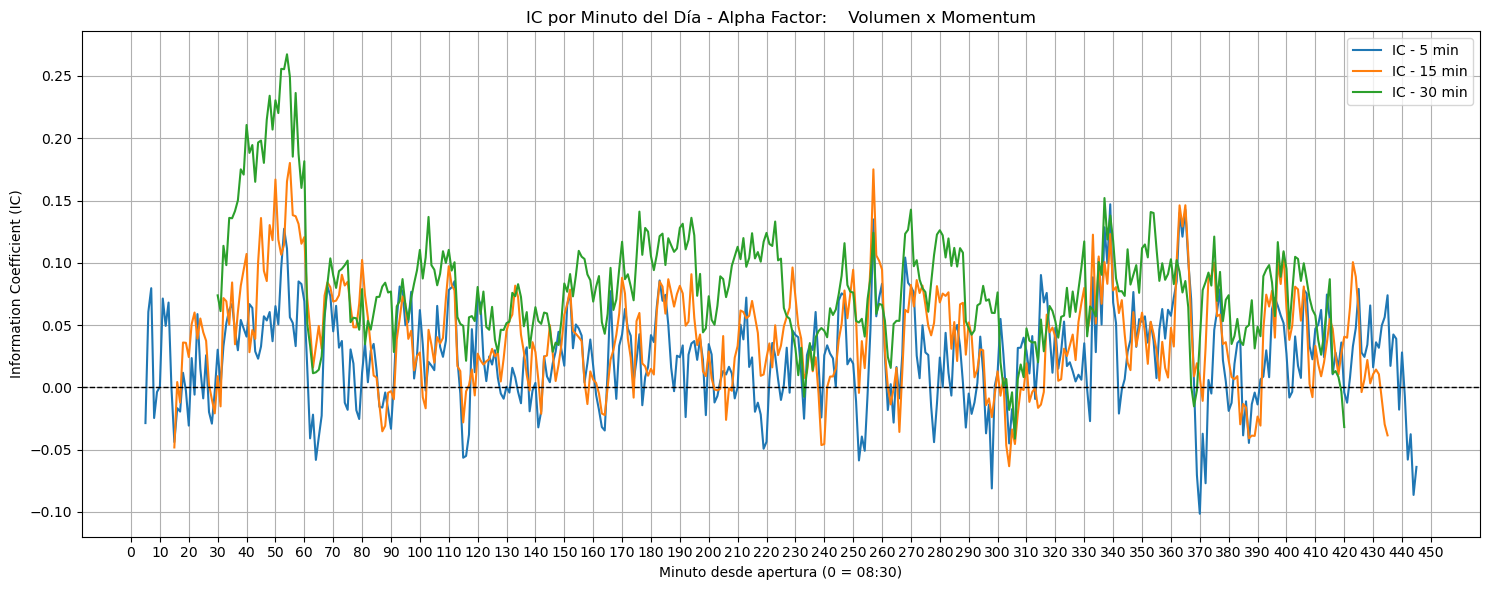

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Asegurarse de tener un identificador de fila por jornada (0 a 450)
mnq_intraday['minute_index'] = mnq_intraday.groupby('date').cumcount()

# Función para calcular IC por minuto
def compute_ic_by_minute(factor_col, target_col):
    grouped = mnq_intraday[[factor_col, target_col, 'minute_index']].dropna()
    ic_by_minute = grouped.groupby('minute_index').apply(
        lambda x: x[factor_col].corr(x[target_col])
    )
    return ic_by_minute

# Calcular IC por minuto para alpha factor momentum x volumen (con reversión)
ic_minute_5 = compute_ic_by_minute('mom_vol_z_5', 'target_return_5')
ic_minute_15 = compute_ic_by_minute('mom_vol_z_15', 'target_return_15')
ic_minute_30 = compute_ic_by_minute('mom_vol_z_30', 'target_return_30')


# Visualización
plt.figure(figsize=(15, 6))
plt.xticks(np.arange(0, 451, 10))
plt.plot(ic_minute_5.index, ic_minute_5, label='IC - 5 min')
plt.plot(ic_minute_15.index, ic_minute_15, label='IC - 15 min')
plt.plot(ic_minute_30.index, ic_minute_30, label='IC - 30 min')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('IC por Minuto del Día - Alpha Factor:    Volumen x Momentum')
plt.xlabel('Minuto desde apertura (0 = 08:30)')
plt.ylabel('Information Coefficient (IC)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
import numpy as np
import pandas as pd

# Asegurarse de tener un identificador de minuto intradía
mnq_intraday['minute_index'] = mnq_intraday.groupby('date').cumcount()

# Recalcular IC por día si no lo hiciste antes
ic_mv_5 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['mom_vol_z_5'].corr(x['target_return_5'])
)
ic_mv_15 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['mom_vol_z_15'].corr(x['target_return_15'])
)
ic_mv_30 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['mom_vol_z_30'].corr(x['target_return_30'])
)

# === RESUMEN GENERAL ===
summary = pd.DataFrame({
    'mean_IC': [ic_mv_5.mean(), ic_mv_15.mean(), ic_mv_30.mean()],
    'std_IC': [ic_mv_5.std(), ic_mv_15.std(), ic_mv_30.std()]
}, index=['mom_vol_z_5', 'mom_vol_z_15', 'mom_vol_z_30'])

# Sharpe-like ratio: mean / std
summary['IC_score'] = summary['mean_IC'] / summary['std_IC']

# === IC promedio por minuto intradía ===
def compute_ic_by_minute(factor_col, target_col):
    grouped = mnq_intraday[[factor_col, target_col, 'minute_index']].dropna()
    return grouped.groupby('minute_index').apply(lambda x: x[factor_col].corr(x[target_col]))

ic_minute_5 = compute_ic_by_minute('mom_vol_z_5', 'target_return_5')
ic_minute_15 = compute_ic_by_minute('mom_vol_z_15', 'target_return_15')
ic_minute_30 = compute_ic_by_minute('mom_vol_z_30', 'target_return_30')

summary['mean_IC_intraday'] = [ic_minute_5.mean(), ic_minute_15.mean(), ic_minute_30.mean()]

# === Robustez temporal (3 períodos) ===
dates = mnq_intraday['date'].dropna().unique()
split_1, split_2, split_3 = np.array_split(dates, 3)

def compute_period_mean_ic(dates_subset, factor_col, target_col):
    df = mnq_intraday[mnq_intraday['date'].isin(dates_subset)].dropna()
    return df.groupby('date').apply(lambda x: x[factor_col].corr(x[target_col])).mean()

summary['IC_period1'] = [
    compute_period_mean_ic(split_1, 'mom_vol_z_5', 'target_return_5'),
    compute_period_mean_ic(split_1, 'mom_vol_z_15', 'target_return_15'),
    compute_period_mean_ic(split_1, 'mom_vol_z_30', 'target_return_30')
]
summary['IC_period2'] = [
    compute_period_mean_ic(split_2, 'mom_vol_z_5', 'target_return_5'),
    compute_period_mean_ic(split_2, 'mom_vol_z_15', 'target_return_15'),
    compute_period_mean_ic(split_2, 'mom_vol_z_30', 'target_return_30')
]
summary['IC_period3'] = [
    compute_period_mean_ic(split_3, 'mom_vol_z_5', 'target_return_5'),
    compute_period_mean_ic(split_3, 'mom_vol_z_15', 'target_return_15'),
    compute_period_mean_ic(split_3, 'mom_vol_z_30', 'target_return_30')
]

# Mostrar tabla resumen
print(summary.round(4))

              mean_IC  std_IC  IC_score  mean_IC_intraday  IC_period1  \
mom_vol_z_5    0.0305  0.1037    0.2938            0.0243      0.0363   
mom_vol_z_15   0.0592  0.1544    0.3836            0.0400      0.0696   
mom_vol_z_30   0.0981  0.2051    0.4783            0.0815      0.1115   

              IC_period2  IC_period3  
mom_vol_z_5       0.0320      0.0230  
mom_vol_z_15      0.0545      0.0536  
mom_vol_z_30      0.0892      0.0935  


### 🏆 Mejor Alpha Factor: `mom_vol_z_30`

El alpha factor `mom_vol_z_30` —basado en momentum × volumen con una ventana de 30 minutos— demuestra ser el más sólido según todos los criterios evaluados:

| Métrica              | Valor más alto | Ganador        |
|----------------------|----------------|----------------|
| `mean_IC`            | **0.0981**     | `mom_vol_z_30` |
| `IC_score`           | **0.4783**     | `mom_vol_z_30` |
| `mean_IC_intraday`   | **0.0815**     | `mom_vol_z_30` |
| `IC_period1`         | **0.1115**     | `mom_vol_z_30` |
| `IC_period2`         | **0.0892**     | `mom_vol_z_30` |
| `IC_period3`         | **0.0935**     | `mom_vol_z_30` |

---

### ✅ ¿Por qué elegir `mom_vol_z_30`?

- Tiene el **mayor IC promedio**, lo que indica **mejor capacidad predictiva general**.
- Su `IC_score` es el más alto, mostrando **mayor estabilidad estadística**.
- La **robustez temporal** está validada: mantiene buen rendimiento en los tres tercios del dataset.
- También presenta **mejor consistencia intradía** (promedio de IC por minuto).

---

### 🧭 Recomendación

> Usar `mom_vol_z_30` como alpha factor principal para estrategias intradía basadas en reversión.

Posibles aplicaciones:

- Como **input para modelos de ML**.
- Como **señal binaria de trading**:  
  ```python
  mnq_intraday['signal'] = np.sign(mom_vol_z_30)


### AGREGAR ALPHA FACTOR A DATASET 

In [ ]:
def add_mom_vol_factor(df: pd.DataFrame, window: int = 30,
                       price_col: str = 'close', volume_col: str = 'volume',
                       date_col: str = 'date') -> pd.DataFrame:
    """
    Agrega un alpha factor basado en momentum x volumen relativo, normalizado por jornada.
    Diseñado para datasets intradía con estructura diaria independiente.

    Parámetros:
    - df: DataFrame original con columnas de precios, volumen y fecha.
    - window: Ventana (en minutos) para cálculo del momentum y volumen promedio.
    - price_col: Columna del precio (default = 'close').
    - volume_col: Columna del volumen (default = 'volume').
    - date_col: Columna que indica la jornada (default = 'date').

    Retorna:
    - DataFrame con columna adicional: 'mom_vol_z_{window}'
    """
    df = df.copy()

    momentum_col = f'momentum_{window}'
    vol_avg_col = f'vol_avg_{window}'
    vol_ratio_col = f'vol_ratio_{window}'
    factor_col = f'mom_vol_{window}'
    z_col = f'mom_vol_z_{window}'

    # Calcular momentum por día: log-retorno contra valor N minutos atrás
    df[momentum_col] = df.groupby(date_col)[price_col].transform(
        lambda x: np.log(x) - np.log(x.shift(window))
    )

    # Volumen promedio (rolling por día)
    df[vol_avg_col] = df.groupby(date_col)[volume_col].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )

    # Ratio volumen actual vs promedio
    df[vol_ratio_col] = df[volume_col] / df[vol_avg_col]

    # Alpha factor (con reversión)
    df[factor_col] = -1 * df[momentum_col] * df[vol_ratio_col]

    # Normalización por día (z-score)
    df[z_col] = df.groupby(date_col)[factor_col].transform(
        lambda x: (x - x.mean()) / x.std()
    )

    return df

In [ ]:
mnq_intraday = add_mom_vol_factor(mnq_intraday, window=30)
